## Importing libraries

In [617]:
# loading data
import urllib.request

# data manipulation
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
# enable interactive plot in the notebook
%matplotlib notebook

# machine learning methods
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

## Loading and formatting the data

In [708]:
# API URL to underground water levels in Ljubljana aquifer
# station with id 85076 is 1279238400Lj - RTV (0261) Ljubljansko polje
url = "http://atena.ijs.si:8080/CollectorAPIServer/undergroundWater?station_id=85012";
jsonStr = urllib.request.urlopen(url).read().decode('utf-8');
df = pd.read_json(jsonStr);

# converting unix timestamp to date-time object
df['Date'] = df['LastUpdatedEpoch'];
df['Date'] = pd.to_datetime(df['Date'], unit='ms');

# remove unneccessary fields
df.drop('LastUpdated', 1, inplace=True);
df.drop('LastUpdatedEpoch', 1, inplace=True);
df.drop('Region_id', 1, inplace=True);
df.drop('Region_name', 1, inplace=True);
df.drop('Station_id', 1, inplace=True);
df.drop('Station_name', 1, inplace=True);
df.drop('SystemCodeNumber', 1, inplace=True);

## Checking loaded data

In [709]:
# string/tabular view
# len(jsonStr), jsonStr[0:100] and df[0:5]
df[0:5]

Value       Date
0  289.27 2001-01-01
1  289.24 2001-01-02
2  289.22 2001-01-03
3  289.29 2001-01-04
4  289.25 2001-01-05

<IPython.core.display.Javascript object>


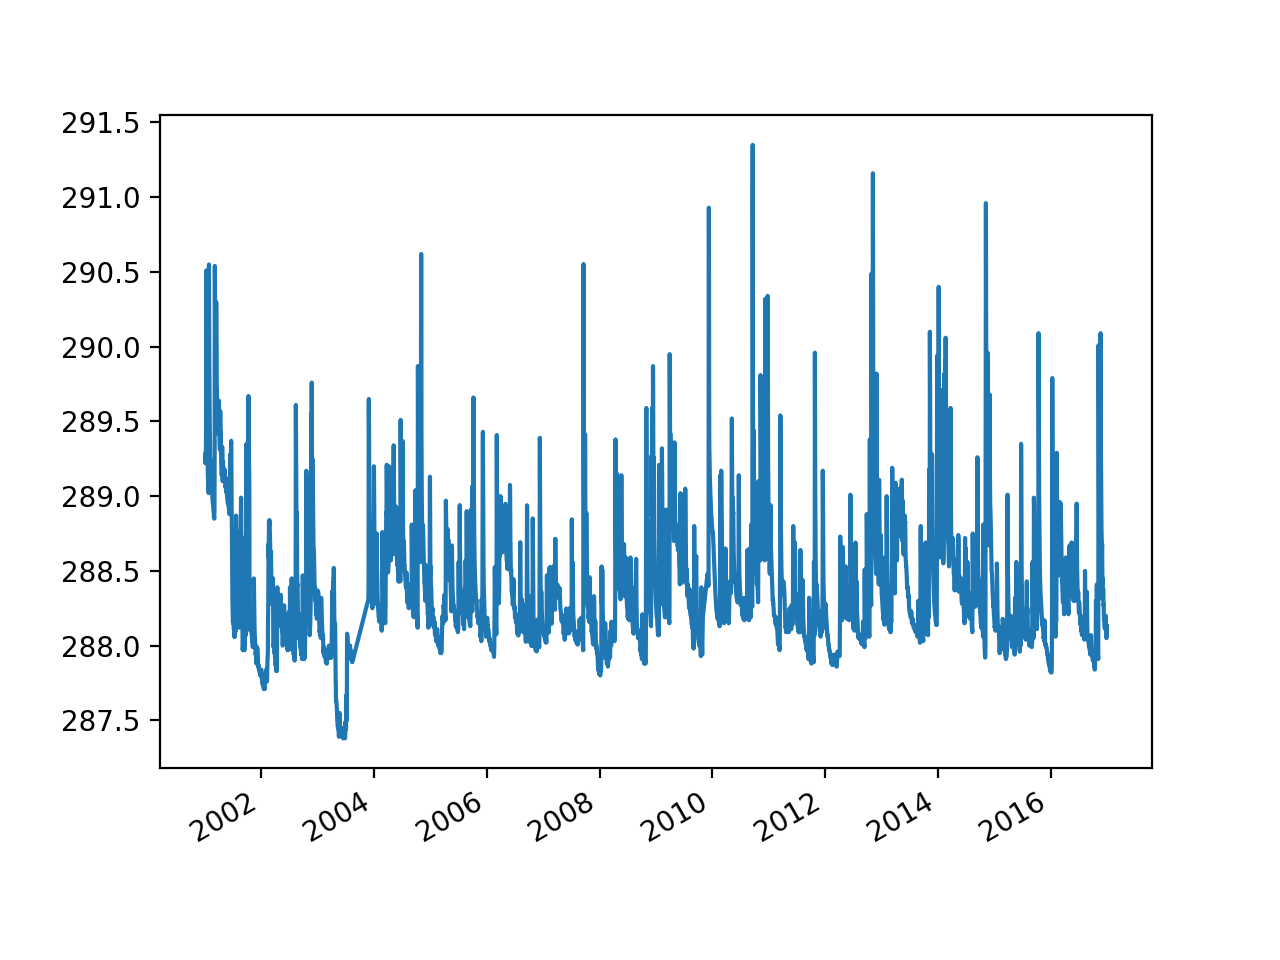

In [710]:
# plotting the data
# format date axis
fig, ax = plt.subplots(); fig.autofmt_xdate();
# plot
ax.plot(df['Date'], df['Value']);
# show plot
plt.show();

## Loading some additional data for modeling (weather)

In [635]:
# API URL to underground water levels in Ljubljana aquifer
# station with id 85076 is 1279238400Lj - RTV (0261) Ljubljansko polje
url = "http://atena.ijs.si:8080/CollectorAPIServer/weather?time_from=31/12/2014&time_to=01/01/2017&city=Ljubljana";
jsonStr = urllib.request.urlopen(url).read().decode('utf-8');
dw = pd.read_json(jsonStr);

# converting unix timestamp to date-time object
dw['Date'] = dw['LastUpdatedEpoch'];
dw['Date'] = pd.to_datetime(dw['Date'] + 2 * 60 * 60 * 1000, unit='ms').dt.round("1d");
dw.set_index('Date', inplace=True);

dw.drop('City', 1, inplace=True);
dw.drop('LastUpdated', 1, inplace=True);
dw.drop('LastUpdatedEpoch', 1, inplace=True);
dw.drop('Sensor_id', 1, inplace=True);
dw.drop('Sensor_name', 1, inplace=True);
dw.drop('SystemCodeNumber', 1, inplace=True);


In [636]:
dw[0:5]

CloudCover  New_snow_blanket  Percipitation  Snow_blanket  \
Date                                                                    
2015-01-01          70                 0            0.0            13   
2015-01-02          83                 0            0.0            12   
2015-01-03          80                 0            0.0            10   
2015-01-04          20                 0            0.2             8   
2015-01-05          50                 0            0.0             4   

            Sun_duration  TemperatureAvg  TemperatureMax  TemperatureMin  
Date                                                                      
2015-01-01           2.1            -5.8            -3.0            -9.6  
2015-01-02           2.1            -0.6             1.5            -5.5  
2015-01-03           0.0            -1.0             0.6            -4.5  
2015-01-04           7.9             3.1            10.3            -0.5  
2015-01-05           5.9             3.0             8.5             0.0

## Data Fusion

In [711]:
# make date a key in our data
df.set_index('Date', inplace=True);

In [712]:
df = df.loc['2014-12-31':'2017-01-01']

In [713]:
df[0:5]

Value
Date              
2014-12-31  288.20
2015-01-01  288.18
2015-01-02  288.16
2015-01-03  288.13
2015-01-04  288.12

In [714]:
# generate fused dataset
ds = pd.concat([df, dw], axis=1);

In [715]:
# let's check it
ds[-10:]

Value  CloudCover  New_snow_blanket  Percipitation  Snow_blanket  \
Date                                                                            
2016-12-22  288.18       100.0               0.0            0.0           0.0   
2016-12-23  288.20        50.0               0.0            0.0           0.0   
2016-12-24  288.17        83.0               0.0            0.0           0.0   
2016-12-25  288.14        97.0               0.0            0.0           0.0   
2016-12-26  288.09        63.0               0.0            0.0           0.0   
2016-12-27  288.07        30.0               0.0            0.0           0.0   
2016-12-28  288.05        70.0               0.0            0.0           0.0   
2016-12-29  288.07        13.0               0.0            0.1           0.0   
2016-12-30  288.07         0.0               0.0            0.0           0.0   
2016-12-31  288.13         3.0               0.0            0.0           0.0   

            Sun_duration  TemperatureAvg  TemperatureMax  TemperatureMin  
Date                                                                      
2016-12-22           0.0            -3.3            -2.7            -4.1  
2016-12-23           2.0            -3.3            -0.8            -4.0  
2016-12-24           0.5            -2.5             0.5            -5.5  
2016-12-25           0.0            -2.3             0.3            -3.7  
2016-12-26           5.5             0.3             6.8            -3.5  
2016-12-27           6.8             3.6             8.9            -1.2  
2016-12-28           6.2             5.3            13.1            -1.0  
2016-12-29           8.1            -0.5             4.2            -2.4  
2016-12-30           5.7            -2.9             2.0            -6.6  
2016-12-31           7.5            -3.5             3.0            -7.6

# .........

In [716]:
ds['DValue'] = ds['Value'] - ds['Value'].shift(1)

In [717]:
#dnew = ds
#for i in range(26):
#    dnew['Sun_duration' + '_shift_' + str(i)+'d'] = ds['Sun_duration'].shift(i)
#for i in range(50,101,10):
#    dnew['Sun_duration' + '_shift_' + str(i)+'d'] = ds['Sun_duration'].shift(i)

In [718]:
#shift of data for n days
def shift_of_data(string, data, new_data):
    for i in range(26):
        new_data[string + '_shift_' + str(i)+'d'] = data[string].shift(i)
    for i in range(30,101,10):
        new_data[string + '_shift_' + str(i)+'d'] = data[string].shift(i)

In [719]:
import copy
dnew = copy.deepcopy(ds)

data_names = ['CloudCover', 'New_snow_blanket', 'Percipitation','Snow_blanket',
              'Sun_duration', 'TemperatureAvg', 'TemperatureMax', 'TemperatureMin']

for string in data_names:
    shift_of_data(string, ds, dnew)

In [720]:
dnew

Value  CloudCover  New_snow_blanket  Percipitation  Snow_blanket  \
Date                                                                            
2014-12-31  288.20         NaN               NaN            NaN           NaN   
2015-01-01  288.18        70.0               0.0            0.0          13.0   
2015-01-02  288.16        83.0               0.0            0.0          12.0   
2015-01-03  288.13        80.0               0.0            0.0          10.0   
2015-01-04  288.12        20.0               0.0            0.2           8.0   
2015-01-05  288.13        50.0               0.0            0.0           4.0   
2015-01-06  288.12        33.0               0.0            0.0           3.0   
2015-01-07  288.13        50.0               0.0            0.0           3.0   
2015-01-08  288.11        83.0               0.0            0.0           3.0   
2015-01-09  288.10        90.0               0.0            0.0           2.0   
2015-01-10  288.11        40.0               0.0            0.0           0.0   
2015-01-11  288.13        73.0               0.0            0.0           0.0   
2015-01-12  288.19        43.0               0.0           20.7           0.0   
2015-01-13  288.17        67.0               0.0            0.0           0.0   
2015-01-14  288.17        93.0               0.0            0.0           0.0   
2015-01-15  288.17        83.0               0.0            0.2           0.0   
2015-01-16  288.15        97.0               0.0            0.0           0.0   
2015-01-17  288.21        97.0               0.0            0.3           0.0   
2015-01-18  288.55        63.0               0.0            2.6           0.0   
2015-01-19  288.51        47.0               0.0            0.0           0.0   
2015-01-20  288.40        90.0               0.0            0.0           0.0   
2015-01-21  288.30       100.0               0.0            0.0           0.0   
2015-01-22  288.23       100.0               0.0            5.9           0.0   
2015-01-23  288.16        93.0               0.0            0.2           0.0   
2015-01-24  288.13        93.0               0.0            0.1           0.0   
2015-01-25  288.12        77.0               0.0            0.5           0.0   
2015-01-26  288.10        27.0               0.0            0.0           0.0   
2015-01-27  288.12        73.0               0.0            0.0           0.0   
2015-01-28  288.10        50.0               0.0            0.0           0.0   
2015-01-29  288.13       100.0               0.0            0.0           0.0   
2015-01-30  288.12       100.0               7.0           11.0           7.0   
2015-01-31  288.10        80.0               9.0           28.0          15.0   
2015-02-01  288.07       100.0               0.0            0.3          13.0   
2015-02-02  288.03        80.0               4.0            6.7          16.0   
2015-02-03  287.99       100.0               0.0            0.0          16.0   
2015-02-04  287.96       100.0              12.0            9.5          28.0   
2015-02-05  287.95       100.0               2.0            2.5          22.0   
2015-02-06  287.95       100.0               3.0            1.8          25.0   
2015-02-07  287.99        60.0               0.0            0.4          23.0   
2015-02-08  287.98        60.0               0.0            0.0          21.0   
2015-02-09  287.99        67.0               0.0            0.0          18.0   
2015-02-10  287.98        53.0               0.0            0.0          18.0   
2015-02-11  287.97        60.0               0.0            0.0          15.0   
2015-02-12  287.97       100.0               0.0            0.0          11.0   
2015-02-13  287.99        80.0               0.0            0.0           9.0   
2015-02-14  288.00       100.0               0.0            0.0           7.0   
2015-02-15  287.98        47.0               0.0            2.4           6.0   
2015-02-16  287.98        47.0              

In [721]:
dnew.corr()

Value  CloudCover  New_snow_blanket  \
Value                        1.000000    0.167822         -0.044420   
CloudCover                   0.167822    1.000000          0.122452   
New_snow_blanket            -0.044420    0.122452          1.000000   
Percipitation                0.349605    0.219788          0.182088   
Snow_blanket                -0.151059    0.162879          0.518093   
Sun_duration                -0.120050   -0.832740         -0.111978   
TemperatureAvg              -0.057861   -0.315040         -0.162496   
TemperatureMax              -0.074827   -0.429054         -0.171834   
TemperatureMin              -0.019444   -0.138423         -0.143569   
DValue                       0.226880    0.088799         -0.006344   
CloudCover_shift_0d          0.167822    1.000000          0.122452   
CloudCover_shift_1d          0.255581    0.535900          0.148517   
CloudCover_shift_2d          0.292424    0.326962          0.068278   
CloudCover_shift_3d          0.267689    0.246793          0.037205   
CloudCover_shift_4d          0.245253    0.209001          0.070724   
CloudCover_shift_5d          0.234299    0.192510          0.073030   
CloudCover_shift_6d          0.217052    0.169997          0.038722   
CloudCover_shift_7d          0.215759    0.112699         -0.007547   
CloudCover_shift_8d          0.216429    0.097493          0.019732   
CloudCover_shift_9d          0.215381    0.064394         -0.034342   
CloudCover_shift_10d         0.211538    0.056383          0.046551   
CloudCover_shift_11d         0.211785    0.009371          0.011331   
CloudCover_shift_12d         0.209130    0.006409         -0.002042   
CloudCover_shift_13d         0.210526    0.002578          0.080994   
CloudCover_shift_14d         0.195477    0.019193          0.101570   
CloudCover_shift_15d         0.165116    0.043616          0.047187   
CloudCover_shift_16d         0.134590    0.064651          0.044434   
CloudCover_shift_17d         0.124099    0.037111          0.045007   
CloudCover_shift_18d         0.108718    0.082302          0.025540   
CloudCover_shift_19d         0.094217    0.083051          0.066368   
CloudCover_shift_20d         0.086492    0.079536          0.064275   
CloudCover_shift_21d         0.086049    0.072229          0.015427   
CloudCover_shift_22d         0.089368    0.061167          0.024393   
CloudCover_shift_23d         0.076136    0.079270          0.002166   
CloudCover_shift_24d         0.070497    0.084673         -0.015196   
CloudCover_shift_25d         0.084245    0.071912         -0.014015   
CloudCover_shift_30d         0.141276    0.028774          0.018321   
CloudCover_shift_40d         0.122635   -0.007412          0.032226   
CloudCover_shift_50d         0.078423    0.004229          0.010304   
CloudCover_shift_60d         0.070035    0.053163         -0.007501   
CloudCover_shift_70d        -0.077108    0.009778          0.063291   
CloudCover_shift_80d         0.048527   -0.013417          0.102382   
CloudCover_shift_90d         0.020847    0.036314          0.009406   
CloudCover_shift_100d       -0.071808   -0.078373         -0.010894   
New_snow_blanket_shift_0d   -0.044420    0.122452          1.000000   
New_snow_blanket_shift_1d   -0.052874    0.115476          0.159250   
New_snow_blanket_shift_2d   -0.047317    0.112793          0.193644   
New_snow_blanket_shift_3d   -0.042790    0.111457          0.120323   
New_snow_blanket_shift_4d   -0.033151    0.108736          0.189127   
New_snow_blanket_shift_5d   -0.019403    0.085844          0.139741   
New_snow_blanket_shift_6d    0.000122    0.067132          0.048462   
New_snow_blanket_shift_7d    0.008052    0.056849          0.018522   
New_snow_blanket_shift_8d    0.018445    0.033255         -0.012915   
New_snow_blanket_shift_9d    0.081840    0.015982         -0.012933   
New_snow_blanket_shift_10d   0.047224    0.059774         -0.012951   
New_snow_blanket_shift_11d   0.023954    0.018862       

In [722]:
#correlation for shifts
#plt.matshow(dnew.corr())

In [723]:
#average for last n days
def average_last_n_days(string, data, new_data):
    for i in range(26):
        new_data[string + '_average_' + str(i)+'d'] = data[string].rolling(i).sum()/i
    for i in range(30,101,10):
        new_data[string + '_average_' + str(i)+'d'] = data[string].rolling(i).sum()/i

In [724]:
#for i in range(26):
#    dnew['Sun_duration' + '_sum_' + str(i)+'d'] = ds['Sun_duration'].rolling(i).sum()

In [725]:
#data_names = ['CloudCover', 'New_snow_blanket', 'Percipitation','Snow_blanket',
#              'Sun_duration', 'TemperatureAvg', 'TemperatureMax', 'TemperatureMin']

#dnew2 = copy.deepcopy(ds)
for string in data_names:
    average_last_n_days(string, ds, dnew)  

In [726]:
#dnew2.corr()

<IPython.core.display.Javascript object>


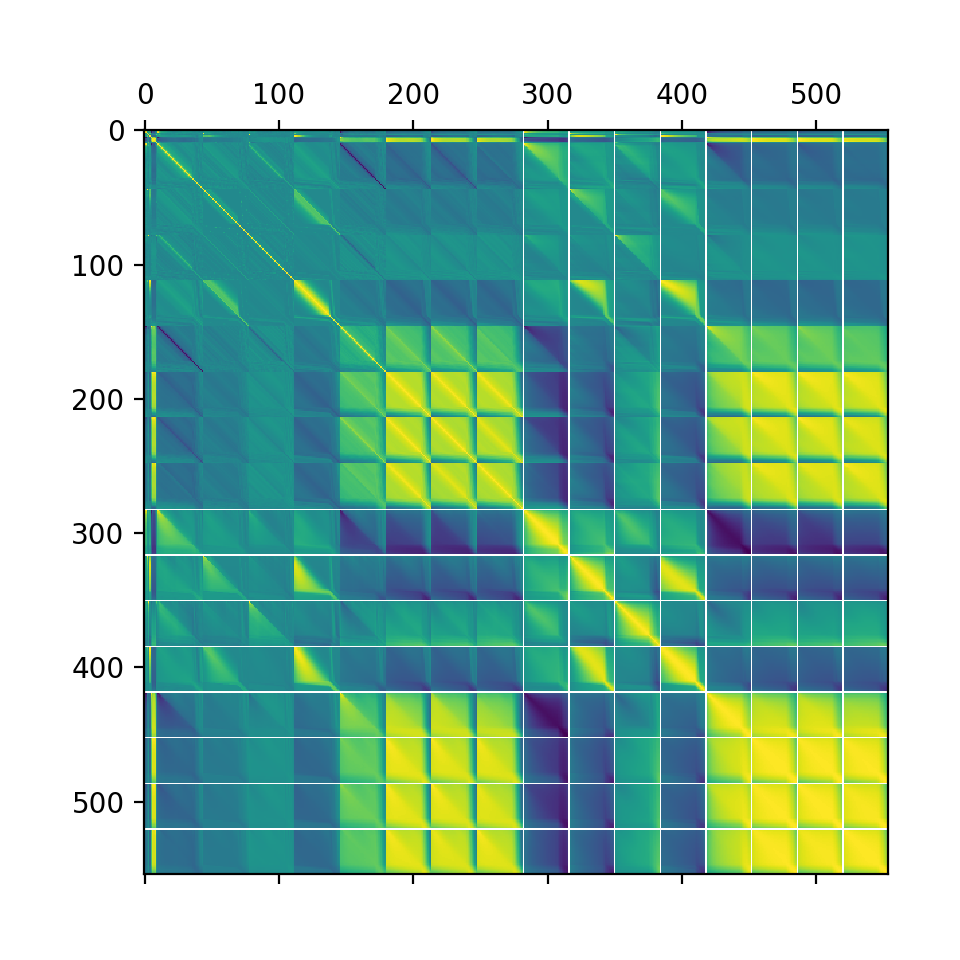

In [727]:
# correlation for shifts and average
plt.matshow(dnew.corr())

In [728]:
dnew.corr()['DValue']

Value                            0.226880
CloudCover                       0.088799
New_snow_blanket                -0.006344
Percipitation                    0.478686
Snow_blanket                    -0.004379
Sun_duration                    -0.091099
TemperatureAvg                   0.013542
TemperatureMax                  -0.002506
TemperatureMin                   0.050005
DValue                           1.000000
CloudCover_shift_0d              0.088799
CloudCover_shift_1d              0.194654
CloudCover_shift_2d              0.081718
CloudCover_shift_3d             -0.054066
CloudCover_shift_4d             -0.049916
CloudCover_shift_5d             -0.023459
CloudCover_shift_6d             -0.038149
CloudCover_shift_7d             -0.004832
CloudCover_shift_8d              0.000362
CloudCover_shift_9d             -0.002000
CloudCover_shift_10d            -0.010688
CloudCover_shift_11d            -0.001660
CloudCover_shift_12d            -0.008034
CloudCover_shift_13d             0

In [729]:
# sort for corelation with 'DValue' from max to min
dsort = dnew.corr().sort_values(['DValue'], ascending = False)

In [730]:
pd.set_option('display.max_rows', 1000)
dsort['DValue']

DValue                           1.000000
Percipitation_average_1d         0.478686
Percipitation                    0.478686
Percipitation_shift_0d           0.478686
Percipitation_average_2d         0.338331
Value                            0.226880
CloudCover_shift_1d              0.194654
Percipitation_average_3d         0.188273
CloudCover_average_2d            0.161681
CloudCover_average_3d            0.151894
New_snow_blanket_shift_9d        0.139826
CloudCover_average_4d            0.104281
Percipitation_average_4d         0.095581
Percipitation_shift_50d          0.095539
CloudCover_shift_0d              0.088799
CloudCover                       0.088799
CloudCover_average_1d            0.088799
CloudCover_shift_2d              0.081718
Snow_blanket_shift_4d            0.075783
CloudCover_average_5d            0.074084
Snow_blanket_shift_3d            0.068422
TemperatureMin_shift_1d          0.061639
CloudCover_average_6d            0.058858
New_snow_blanket_average_10d     0

<IPython.core.display.Javascript object>


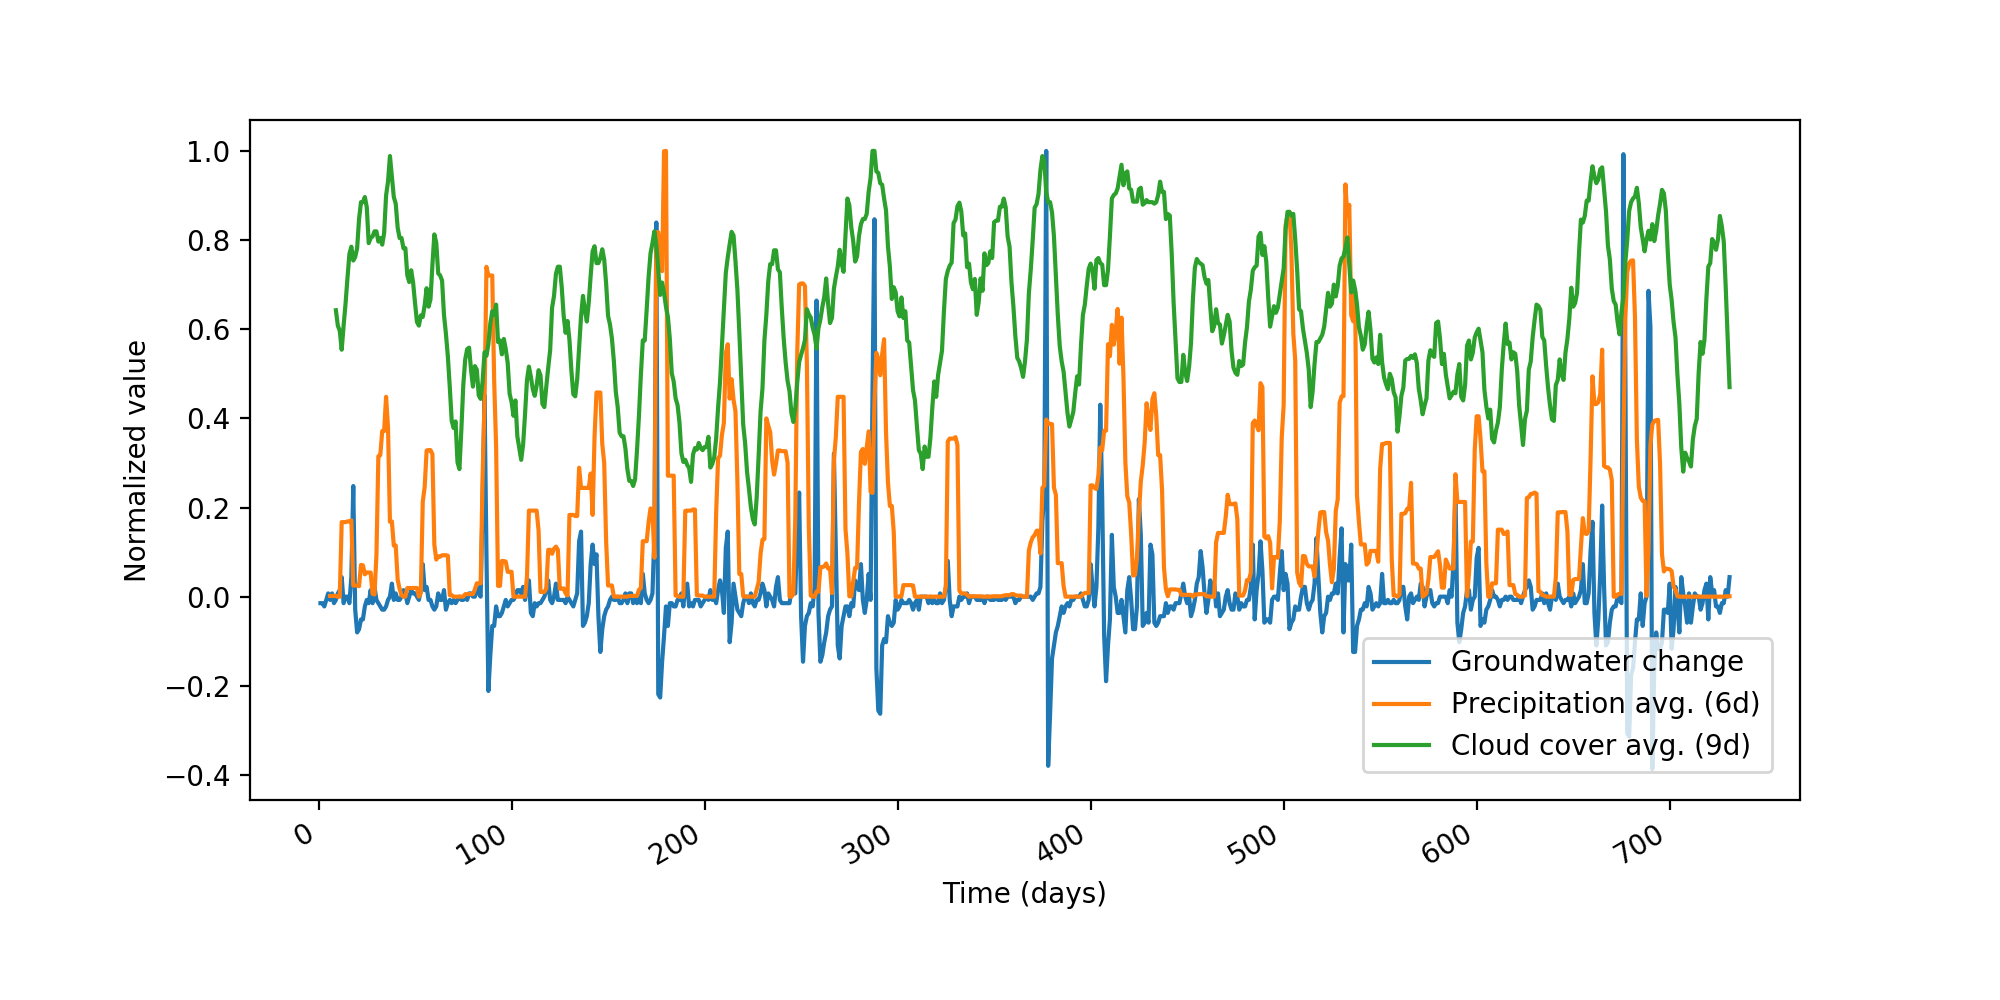

In [731]:
# ploted corelated quantities
fig, ax = plt.subplots(); fig.autofmt_xdate();
fig.set_size_inches(10, 5)
ax.plot(range(732), dnew['DValue'] / np.max(np.abs(dnew['DValue']),axis=0), label="Groundwater change");
ax.plot(range(732), dnew['Percipitation_average_6d'] / np.max(np.abs(dnew['Percipitation_average_6d']),axis=0), label="Precipitation avg. (6d)");
ax.plot(range(732), dnew['CloudCover_average_9d'] / np.max(np.abs(dnew['CloudCover_average_9d']),axis=0), label="Cloud cover avg. (9d)");
ax.legend(loc=4, borderaxespad=1)
plt.xlabel('Time (days)')
plt.ylabel('Normalized value')
plt.show();

In [732]:
fig.savefig('correlations.png', dpi=300)

In [658]:
#create new data frame for chosen colerated quantities
data_corelated = pd.DataFrame()
corelated = ['Percipitation_average_6d',
             'Percipitation_average_10d',
             'Percipitation_average_25d',
             'CloudCover_average_9d',
             'Sun_duration_average_9d'
            ]
data_corelated['DValue'] = copy.deepcopy(dnew['DValue'])

for corelated in corelated:
    data_corelated[corelated] = copy.deepcopy(dnew[corelated])


In [733]:
data_corelated

DValue  Percipitation_average_6d  Percipitation_average_10d  \
Date                                                                      
2014-12-31     NaN                       NaN                        NaN   
2015-01-01     NaN                       NaN                        NaN   
2015-01-02     NaN                       NaN                        NaN   
2015-01-03     NaN                       NaN                        NaN   
2015-01-04     NaN                       NaN                        NaN   
2015-01-05     NaN                       NaN                        NaN   
2015-01-06     NaN              3.333333e-02                        NaN   
2015-01-07     NaN              3.333333e-02                        NaN   
2015-01-08     NaN              3.333333e-02                        NaN   
2015-01-09     NaN              3.333333e-02                        NaN   
2015-01-10  -0.043              0.000000e+00               2.000000e-02   
2015-01-11  -0.050              0.000000e+00               2.000000e-02   
2015-01-12  -0.062              3.450000e+00               2.090000e+00   
2015-01-13  -0.060              3.450000e+00               2.090000e+00   
2015-01-14  -0.044              3.450000e+00               2.070000e+00   
2015-01-15  -0.039              3.483333e+00               2.090000e+00   
2015-01-16  -0.041              3.483333e+00               2.090000e+00   
2015-01-17  -0.045              3.533333e+00               2.120000e+00   
2015-01-18  -0.039              5.166667e-01               2.380000e+00   
2015-01-19  -0.041              5.166667e-01               2.380000e+00   
2015-01-20  -0.047              5.166667e-01               2.380000e+00   
2015-01-21  -0.053              4.833333e-01               2.380000e+00   
2015-01-22  -0.045              1.466667e+00               9.000000e-01   
2015-01-23  -0.032              1.450000e+00               9.200000e-01   
2015-01-24  -0.035              1.033333e+00               9.300000e-01   
2015-01-25  -0.036              1.116667e+00               9.600000e-01   
2015-01-26  -0.040              1.116667e+00               9.600000e-01   
2015-01-27  -0.031              1.116667e+00               9.300000e-01   
2015-01-28  -0.032              1.333333e-01               6.700000e-01   
2015-01-29  -0.036              1.000000e-01               6.700000e-01   
2015-01-30  -0.032              1.916667e+00               1.770000e+00   
2015-01-31  -0.023              6.500000e+00               4.570000e+00   
2015-02-01  -0.017              6.550000e+00               4.010000e+00   
2015-02-02  -0.035              7.666667e+00               4.660000e+00   
2015-02-03  -0.029              7.666667e+00               4.650000e+00   
2015-02-04  -0.037              9.250000e+00               5.550000e+00   
2015-02-05  -0.032              7.833333e+00               5.800000e+00   
2015-02-06  -0.031              3.466667e+00               5.980000e+00   
2015-02-07  -0.031              3.483333e+00               6.020000e+00   
2015-02-08  -0.030              2.366667e+00               6.020000e+00   
2015-02-09  -0.035              2.366667e+00               4.920000e+00   
2015-02-10  -0.040              7.833333e-01               2.120000e+00   
2015-02-11  -0.044              3.666667e-01               2.090000e+00   
2015-02-12  -0.028              6.666667e-02               1.420000e+00   
2015-02-13  -0.042             -7.216450e-16               1.420000e+00   
2015-02-14  -0.034             -7.216450e-16               4.700000e-01   
2015-02-15  -0.027              4.000000e-01               4.600000e-01   
2015-02-16  -0.026              4.000000e-01               2.800000e-01   
2015-02-17  -0.026              4.000000e-01               2.400000e-01   
2015-02-18  -0.037              4.000000e-01               2.400000e-01   
2015-02-19  -0.032              4.000000e-01               2.400000e-01   
2015-02-20  -0.015              4.000

# Learn

In [734]:
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn import tree
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import Normalizer

from sklearn.metrics import mean_squared_error, r2_score

In [661]:
#create arrays x (corelated) and y ('DValue')
#y = dnew['Value']
y = data_corelated['DValue']
y = y.values.astype(np.float)[30:]
X = data_corelated.iloc[:, 1:len(corelated)]
X= X.values.astype(np.float)[30:]

In [735]:
y.shape

(702,)

In [736]:
X.shape

(702, 5)

In [737]:
#choose regressor

regressor = linear_model.LinearRegression();
regressor = DecisionTreeRegressor();
regressor = RandomForestRegressor();
regressor = SVR();
regressor = GradientBoostingRegressor();

In [738]:
#predict
predicted = cross_val_predict(regressor, X, y, cv = 3)

<IPython.core.display.Javascript object>


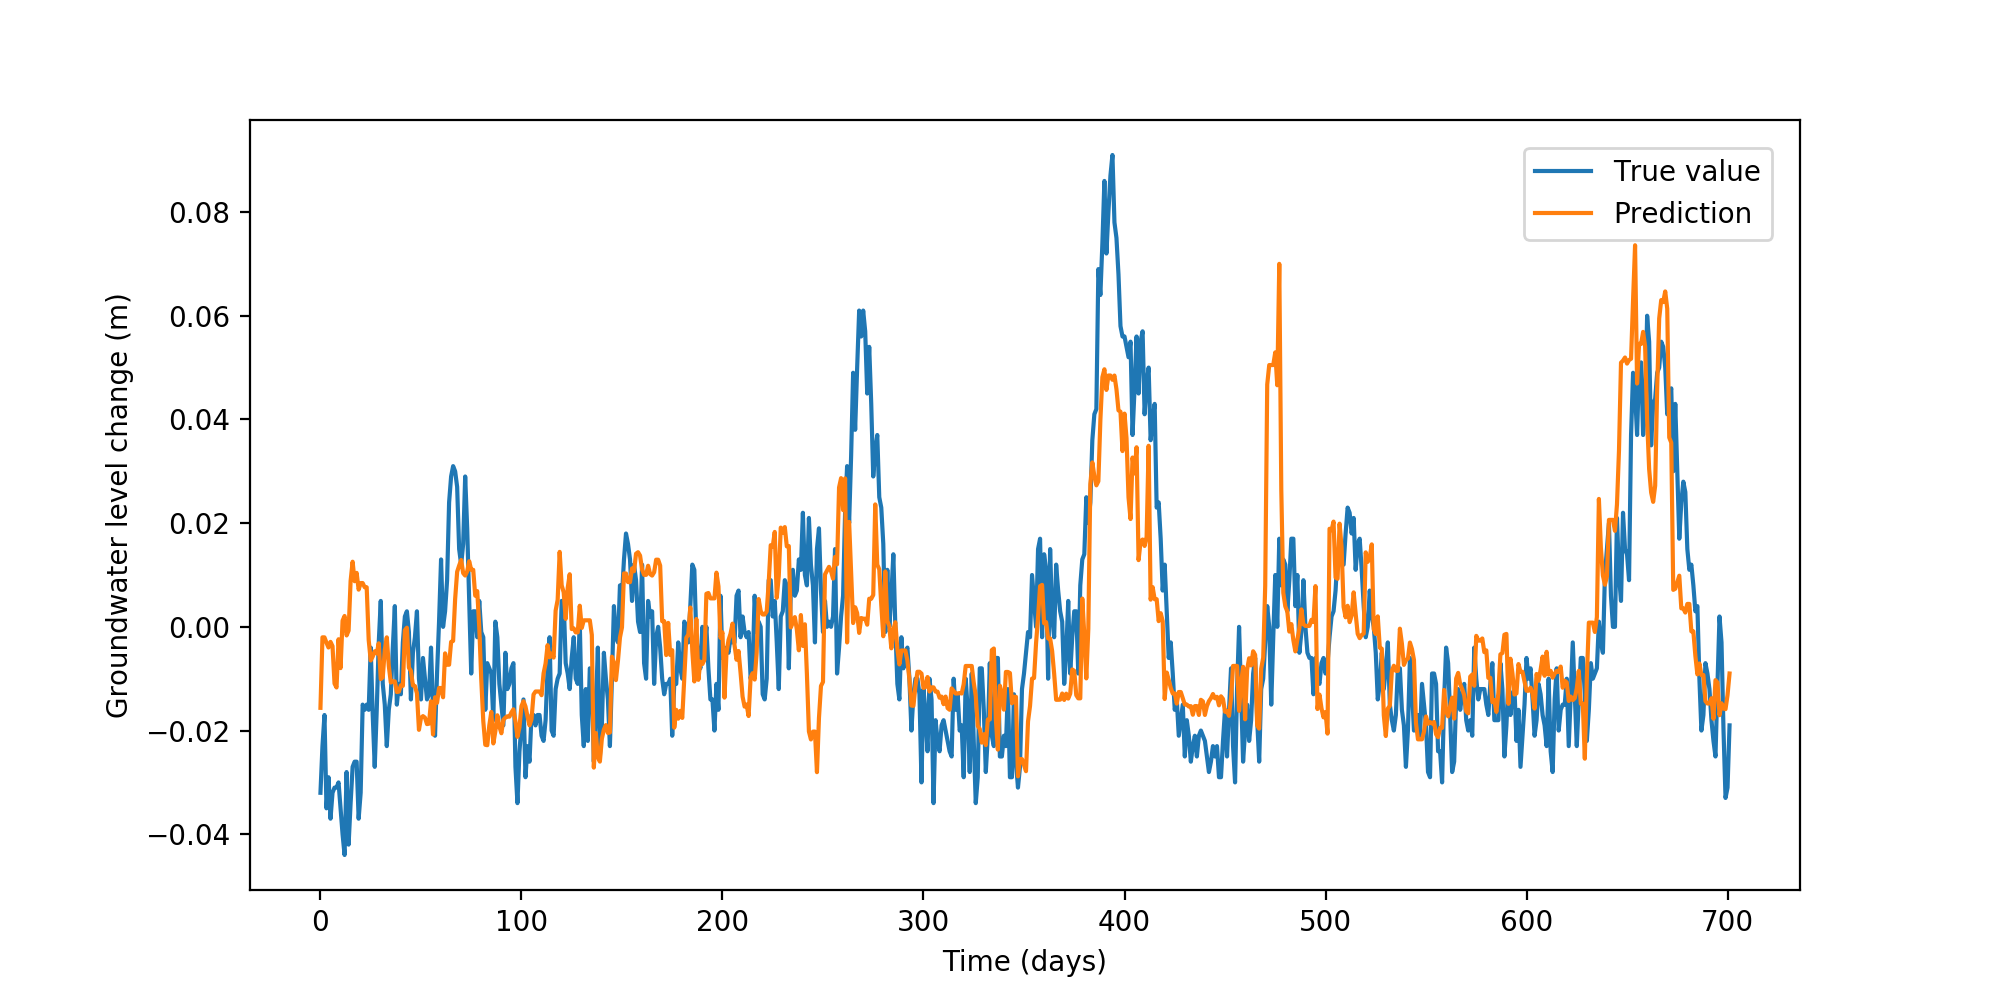

In [751]:
#plot predicted values and real value
fig, ax = plt.subplots(); 
#fig.autofmt_xdate();
fig.set_size_inches(10, 5)
ax.plot(range(702), y, label="True value")
ax.plot(range(702), predicted, label="Prediction");
ax.legend(loc=1, borderaxespad=1)
plt.xlabel('Time (days)')
plt.ylabel('Groundwater level change (m)')
plt.show();

In [550]:
fig.savefig('prediction.png', dpi=300)

In [740]:
#evaluate results

mse = mean_squared_error(y, predicted)
r2 = r2_score(y, predicted);
(mse, r2)

(0.00027860748557629526, 0.44601319884917334)

In [741]:
#evaluation for all regressors
regressor_list = (linear_model.LinearRegression(),
            DecisionTreeRegressor(),
            RandomForestRegressor(),
            SVR(),
            MLPRegressor(),
            GradientBoostingRegressor())

for regressor in regressor_list:
    predicted = cross_val_predict(regressor, X, y, cv = 3)
    mse = mean_squared_error(y, predicted)
    r2 = r2_score(y, predicted);
    print(mse, r2)

0.0002842619130699275 0.4347698605983825
0.0005118091168089618 -0.017688002295910055
0.0003246023736328884 0.3545563564349925
0.0011229515669520498 -1.232891715512487
1.999281665921732 -3974.3980493828903
0.0002804034444136253 0.4424420905954486


In [742]:
#sum
value = ds['Value']
value = value.values.astype(np.float)[30:]

predicted_value = []
predicted_value.append(value[0])
n=1
for i in predicted[1:]:
    predicted_value.append(predicted_value[n-1] + i)
    n += 1

<IPython.core.display.Javascript object>


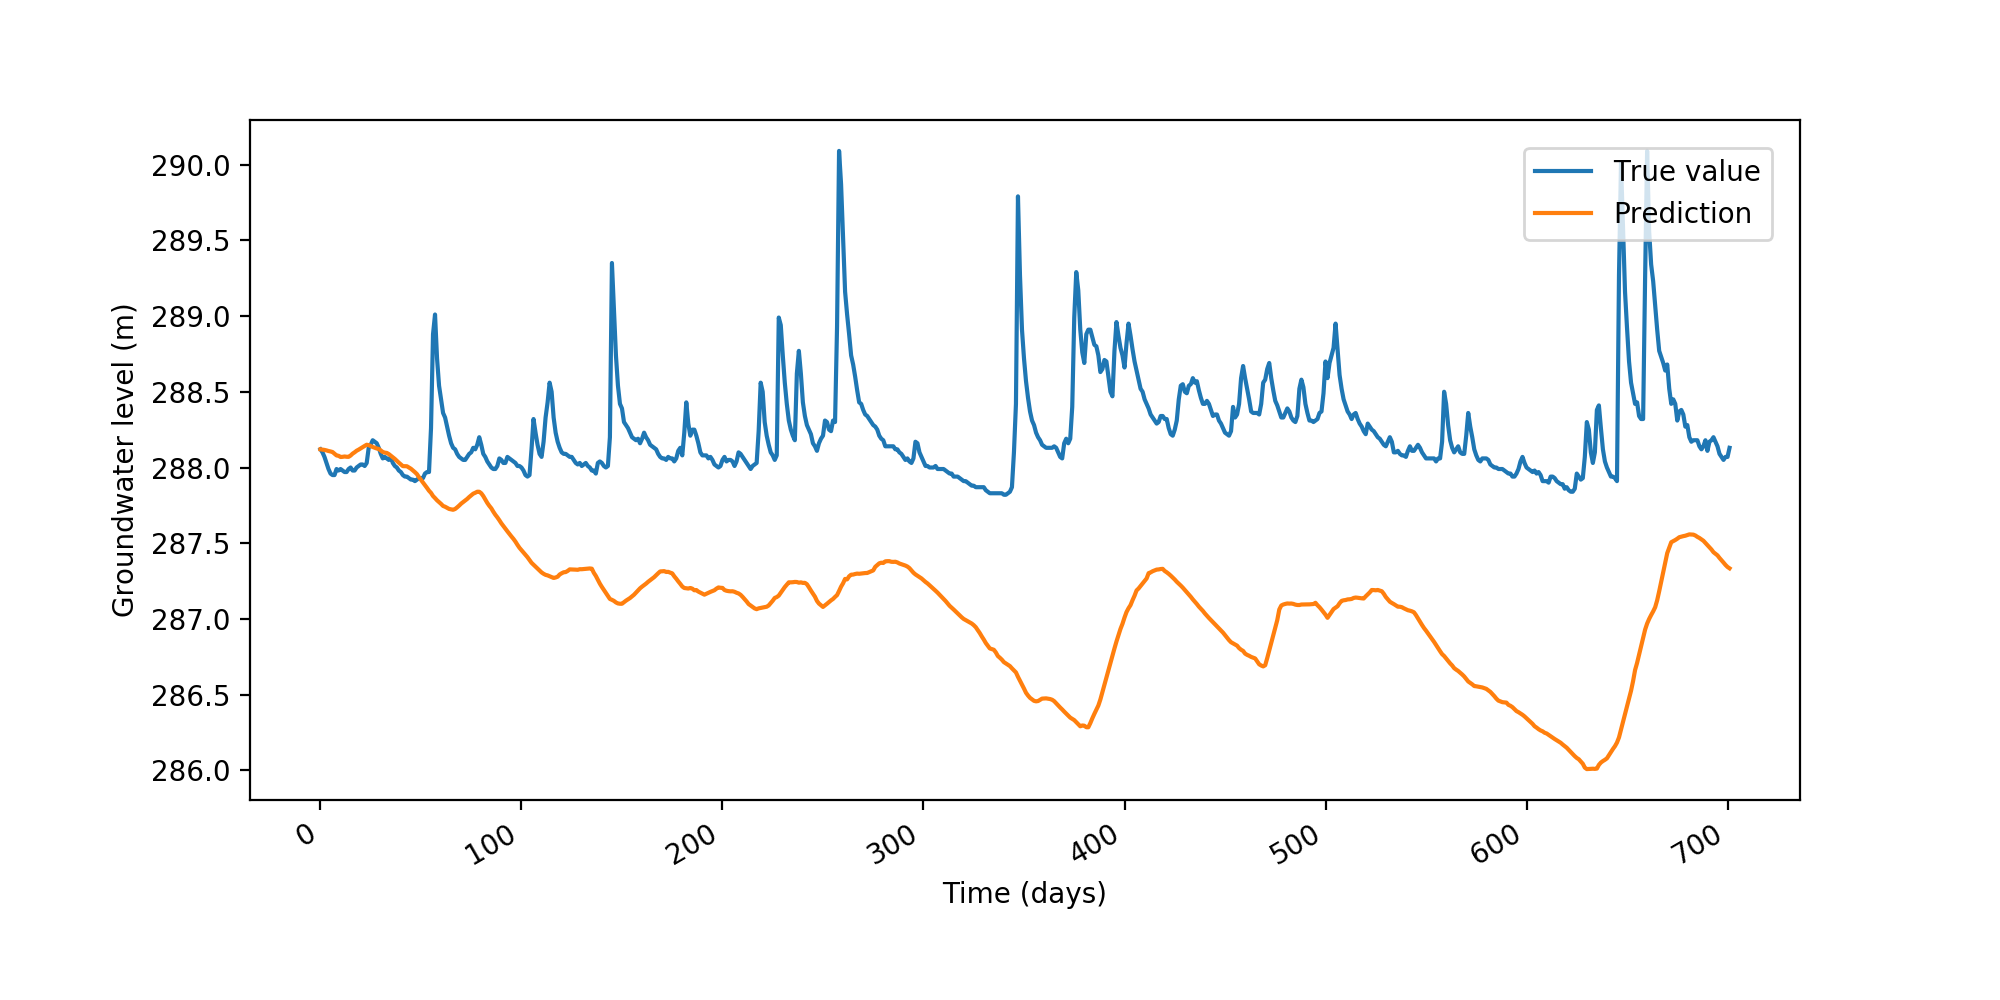

In [743]:
fig, ax = plt.subplots(); fig.autofmt_xdate();
fig.set_size_inches(10, 5)
ax.plot(range(702), value, label="True value");
ax.plot(range(702), predicted_value, label="Prediction");
ax.legend(loc=1, borderaxespad=1)
plt.xlabel('Time (days)')
plt.ylabel('Groundwater level (m)')
plt.show();

In [555]:
fig.savefig('prediction_cum.png', dpi=300)

<IPython.core.display.Javascript object>


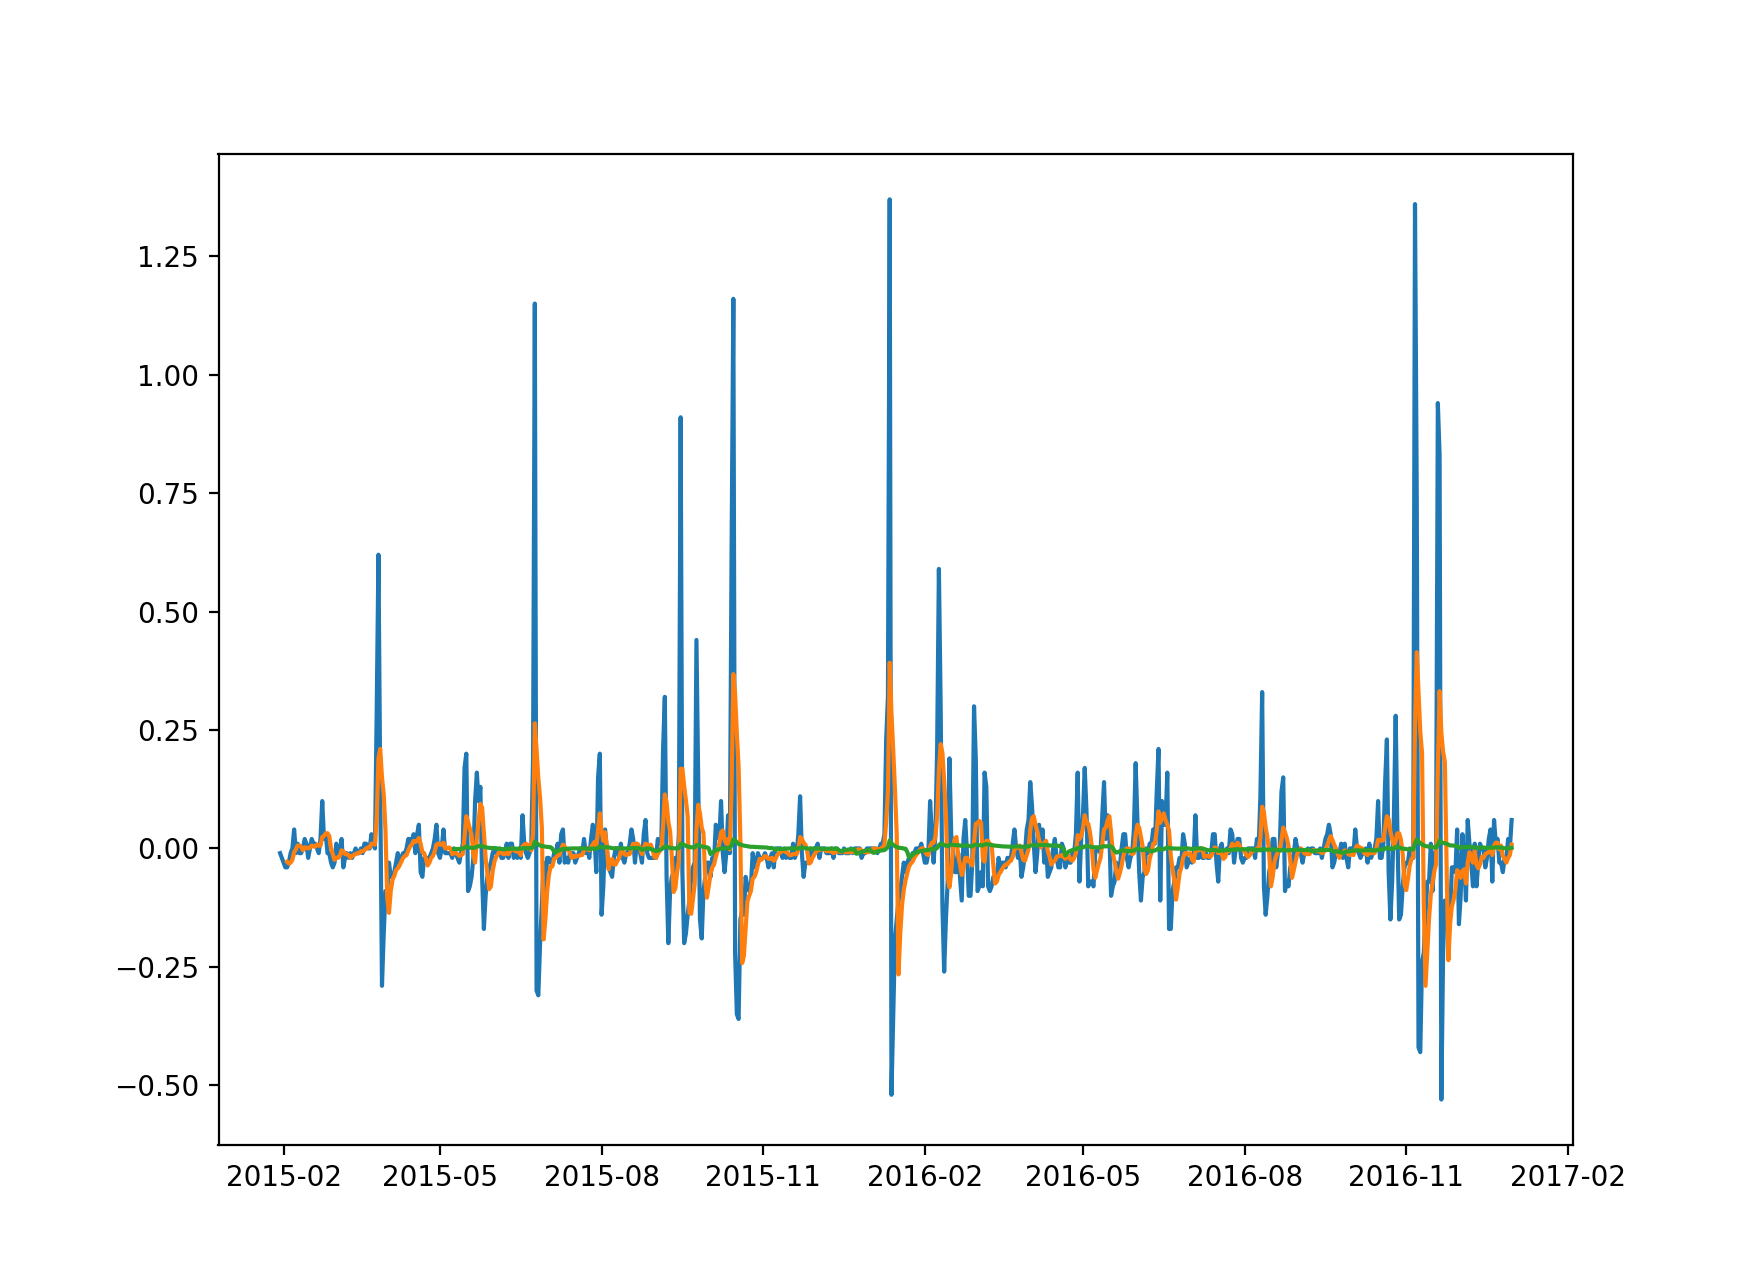

In [750]:
fig, ax = plt.subplots();
ax.plot(ds['DValue'][30:])
ax.plot(ds['DValue'][30:].rolling(5).mean())
ax.plot(ds['DValue'][30:].rolling(100).mean())
plt.show()

In [745]:
ds['DValue'][30:]


Date
2015-01-30   -0.01
2015-01-31   -0.02
2015-02-01   -0.03
2015-02-02   -0.04
2015-02-03   -0.04
2015-02-04   -0.03
2015-02-05   -0.01
2015-02-06    0.00
2015-02-07    0.04
2015-02-08   -0.01
2015-02-09    0.01
2015-02-10   -0.01
2015-02-11   -0.01
2015-02-12    0.00
2015-02-13    0.02
2015-02-14    0.01
2015-02-15   -0.02
2015-02-16    0.00
2015-02-17    0.02
2015-02-18    0.01
2015-02-19    0.01
2015-02-20    0.00
2015-02-21   -0.01
2015-02-22    0.02
2015-02-23    0.10
2015-02-24    0.02
2015-02-25    0.03
2015-02-26   -0.01
2015-02-27   -0.01
2015-02-28   -0.03
2015-03-01   -0.04
2015-03-02   -0.03
2015-03-03    0.01
2015-03-04   -0.01
2015-03-05   -0.01
2015-03-06    0.02
2015-03-07   -0.04
2015-03-08   -0.02
2015-03-09   -0.01
2015-03-10   -0.02
2015-03-11   -0.01
2015-03-12   -0.02
2015-03-13   -0.01
2015-03-14    0.00
2015-03-15   -0.01
2015-03-16   -0.01
2015-03-17    0.00
2015-03-18   -0.01
2015-03-19    0.01
2015-03-20    0.01
2015-03-21    0.00
2015-03-22    0.00
2015-03